In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [36]:
# import data from the csv file
data = pd.read_csv('data_stocks.csv')
print(data.head())

         DATE      SP500  NASDAQ.AAL  NASDAQ.AAPL  NASDAQ.ADBE  NASDAQ.ADI  \
0  1491226200  2363.6101     42.3300     143.6800     129.6300      82.040   
1  1491226260  2364.1001     42.3600     143.7000     130.3200      82.080   
2  1491226320  2362.6799     42.3100     143.6901     130.2250      82.030   
3  1491226380  2364.3101     42.3700     143.6400     130.0729      82.000   
4  1491226440  2364.8501     42.5378     143.6600     129.8800      82.035   

   NASDAQ.ADP  NASDAQ.ADSK  NASDAQ.AKAM  NASDAQ.ALXN  ...  NYSE.WYN  NYSE.XEC  \
0    102.2300      85.2200       59.760       121.52  ...    84.370   119.035   
1    102.1400      85.6500       59.840       121.48  ...    84.370   119.035   
2    102.2125      85.5100       59.795       121.93  ...    84.585   119.260   
3    102.1400      85.4872       59.620       121.44  ...    84.460   119.260   
4    102.0600      85.7001       59.620       121.60  ...    84.470   119.610   

   NYSE.XEL  NYSE.XL  NYSE.XOM  NYSE.XRX  NY

In [37]:
# drop the date from the dataset loaded 
data = data.drop(['DATE'], 1)

#Taking the dimensions of the dataset
n = data.shape[0]
p = data.shape[1]

print(n)
print(p)

41266
501


In [38]:
# make data a numpy array
data = data.values

In [39]:
# training and testing data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end
test_end = n

print(train_start)
print(train_end)
print(test_start)
print(test_end)

data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

print(data_train.shape[0])
print(data_train.shape[1])
print(data_train[0:5,0:5])

0
33012
33012
41266
33012
501
[[2363.6101   42.33    143.68    129.63     82.04  ]
 [2364.1001   42.36    143.7     130.32     82.08  ]
 [2362.6799   42.31    143.6901  130.225    82.03  ]
 [2364.3101   42.37    143.64    130.0729   82.    ]
 [2364.8501   42.5378  143.66    129.88     82.035 ]]


In [40]:
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
print(data_train[0:5,0:5])

[[0.2242253  0.10993038 0.18116315 0.06281066 0.4629156 ]
 [0.2274127  0.11212898 0.18219249 0.09399006 0.46547315]
 [0.21817444 0.10846464 0.18168296 0.08969724 0.46227621]
 [0.22877873 0.11286185 0.17910448 0.08282422 0.46035806]
 [0.23229138 0.1251594  0.18013381 0.07410755 0.46259591]]


In [41]:
# building X & Y from our present dataset
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]
print(X_train)
print(y_train)

[[0.10993038 0.18116315 0.06281066 ... 0.05135952 0.37568157 0.09098787]
 [0.11212898 0.18219249 0.09399006 ... 0.04229607 0.36314068 0.09098787]
 [0.10846464 0.18168296 0.08969724 ... 0.04305136 0.35932388 0.09228769]
 ...
 [0.71161598 0.91890376 0.82919114 ... 0.99622356 0.1504253  0.80025997]
 [0.71015024 0.91148224 0.82964302 ... 0.99471299 0.15267176 0.79896014]
 [0.71015024 0.90787442 0.82647989 ... 0.99358006 0.14830971 0.80069324]]
[0.2242253  0.2274127  0.21817444 ... 0.94913101 0.94789573 0.94633455]


In [42]:
# Model architecture parameters
n_stocks = 500 # No. of Columns
n_neurons_1 = 1024 
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_target = 1

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [43]:

# Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

# Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

# Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

# Layer 4: Variables for hidden weights and biases
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([n_neurons_4, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))


# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer (must be transposed)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

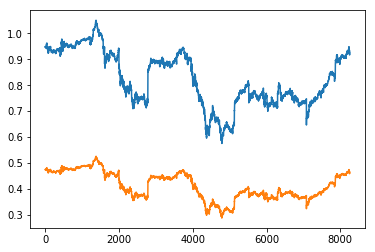

0.008353657


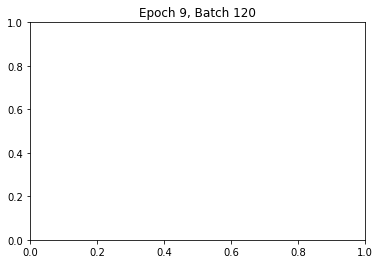

In [46]:
# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)


# Make Session
net = tf.Session()

# Run initializer
net.run(tf.global_variables_initializer())

# Setup interactive plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test*0.5)
plt.show()

# Number of epochs and batch size
epochs = 10
batch_size = 256

for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 10) == 0:
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
            line2.set_ydata(pred)
            plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            #file_name = 'epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
            #plt.savefig(file_name)
            #plt.pause(0.04)

# Print final MSE after Training
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)